In [2]:
import numpy as np
#from qiskit.ml.datasets import wine
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QSVC
#from qiskit.utils.components.multiclass_extensions import AllPairs
#from qiskit.aqua.utils.dataset_helper import get_feature_dimension

from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

In [3]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [7]:
# Load MNIST dataset
DATA_PATH = 'octmnist.npz'
data = np.load(DATA_PATH)

sample_train = data['train_images']
labels_train = data['train_labels']
sample_test = data['test_images']
labels_test = data['test_labels']

sample_train = sample_train[:3766]
#labels_train = labels_train[:3766]
sample_test = sample_test[:200]
labels_test = labels_test[:200]

In [8]:
sample_train.shape

(3766, 28, 28)

In [63]:

labels_test = labels_test.flatten()
print(np.array(labels_test))

[3 2 3 3 0 2 1 0 0 3 0 1 3 3 3 2 2 3 0 2 1 0 0 3 0 0 0 1 2 1 2 1 2 3 2 1 1
 3 0 2 1 2 0 0 3 1 3 1 1 2 1 0 1 0 0 1 2 1 1 1 1 2 3 2 2 0 2 0 2 1 1 1 3 3
 2 2 3 2 3 0 0 2 3 3 3 2 1 2 2 0 2 3 0 1 1 1 1 3 1 0 3 0 0 3 2 2 2 3 1 2 2
 1 0 2 3 3 0 0 3 2 0 2 3 1 0 0 0 2 3 1 1 3 1 0 3 2 1 2 0 0 1 0 0 1 1 2 3 2
 0 1 0 0 0 1 1 0 2 0 2 1 3 3 3 3 2 1 3 1 2 3 1 0 3 0 2 3 2 3 2 0 2 2 1 1 2
 1 1 2 2 2 0 3 3 2 2 0 2 2 1 2]


In [4]:
counts_per_label = {(0,): 0, (1,): 0, (2,): 0, (3,): 0}
filtered_sample_train = []
filtered_labels_train = []

# Iterate through the data to filter by label and save 800 counts of each label
for label, image in zip(labels_train, sample_train):
    label_tuple = tuple(label)
    if counts_per_label[label_tuple] < 800:
        counts_per_label[label_tuple] += 1
        filtered_sample_train.append(image)
        filtered_labels_train.append(label)

    # Break the loop once 800 counts of each label are saved
    if all(count >= 800 for count in counts_per_label.values()):
        break

# Verify the counts of each label in the filtered data
print("Counts per label in filtered data:")
for label, count in counts_per_label.items():
    print(f"Label {label}: {count}")
    
# Convert the lists to arrays if needed
filtered_sample_train = np.array(filtered_sample_train)
filtered_labels_train = np.array(filtered_labels_train)

Counts per label in filtered data:
Label (0,): 800
Label (1,): 800
Label (2,): 800
Label (3,): 800


In [5]:
# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    filtered_sample_train, filtered_labels_train, test_size=0.2, random_state=42)

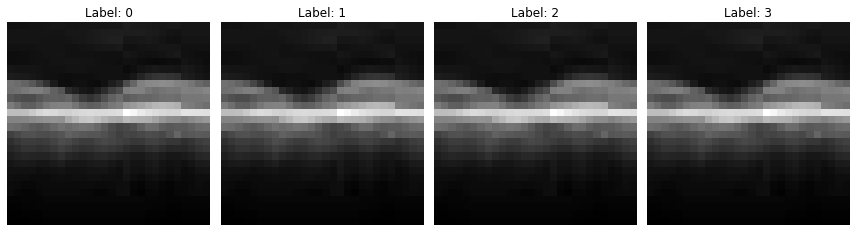

In [6]:
import matplotlib.pyplot as plt

# Define a list of labels to choose from (0, 1, 2, 3)
labels_to_plot = [0, 1, 2, 3]

# Initialize a variable to keep track of the plotted samples
samples_plotted = 0

# Create a new figure
plt.figure(figsize=(12, 6))

# Iterate through the labels
for label in labels_to_plot:
    # Find the first sample with the specified label
    sample_index = np.where(labels_train == label)[1][0]
    
    # Select the sample
    single_sample = sample_train[sample_index]
    
    # Create a subplot for the current sample
    plt.subplot(1, len(labels_to_plot), samples_plotted + 1)
    
    # Display the image and label
    plt.imshow(single_sample, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    
    # Increment the samples_plotted counter
    samples_plotted += 1

# Show the entire plot
plt.tight_layout()
plt.show()


In [124]:
print("Image data shape:", sample_train.shape)

Image data shape: (2560, 28, 28)


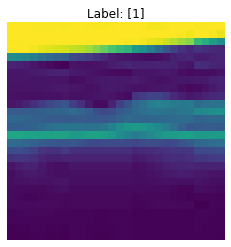

In [125]:
# Select a single sample (e.g., the first one)
single_sample = sample_train[1]

# Display the image using matplotlib
plt.imshow(single_sample)
plt.title(f'Label: {labels_train[0]}')  # Display the corresponding label
plt.axis('off')  # Turn off axis labels
plt.show()

In [7]:
num_samples, num_rows, num_cols = sample_train.shape
sample_train = sample_train.reshape(num_samples, -1)
sample_val = sample_val.reshape(sample_val.shape[0], -1)
sample_test = sample_test.reshape(sample_test.shape[0], -1)

In [8]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

In [128]:
print("Image data shape:", sample_train.shape)

Image data shape: (2560, 784)


### Classical Model

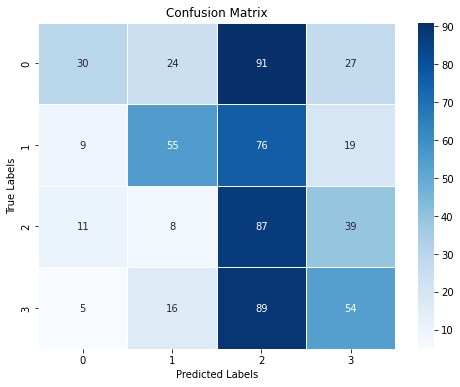

Accuracy: 0.353125
Class 0 - Precision: 0.5454545454545454, Recall: 0.1744186046511628, F1-Score: 0.2643171806167401
Class 1 - Precision: 0.5339805825242718, Recall: 0.34591194968553457, F1-Score: 0.41984732824427484
Class 2 - Precision: 0.2536443148688047, Recall: 0.6, F1-Score: 0.35655737704918034
Class 3 - Precision: 0.38848920863309355, Recall: 0.32926829268292684, F1-Score: 0.3564356435643565


In [129]:
from sklearn import svm
import seaborn as sns

# Create an SVM Classifier with a polynomial kernel
clf = svm.SVC(kernel='poly')

# Train the model using the training sets
clf.fit(sample_train, labels_train)

# Predict the response for the validation dataset
y_pred = clf.predict(sample_val)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create a confusion matrix
confusion = confusion_matrix(labels_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_Matrix_SVM.png")
plt.show()

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
accuracy = metrics.accuracy_score(labels_val, y_pred)
print("Accuracy:", accuracy)

# Model Precision, Recall, and F1-score for each class
precision = metrics.precision_score(labels_val, y_pred, average=None)
recall = metrics.recall_score(labels_val, y_pred, average=None)
f1_score = metrics.f1_score(labels_val, y_pred, average=None)

# Print precision, recall, and F1-score for each class
for class_label in range(4):
    print(f"Class {class_label} - Precision: {precision[class_label]}, Recall: {recall[class_label]}, F1-Score: {f1_score[class_label]}")


### QSVM

In [66]:
# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)


In [67]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [68]:
qsvc1 = QSVC(quantum_kernel=pauli_kernel)
qsvc1.fit(sample_train ,labels_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7fe0f7833af0>,
     random_state=12345, shrinking=True, tol=0.001, verbose=False)

In [69]:
# Calculate accuracy for test dataset
y_pred = qsvc1.predict(sample_train)

In [70]:
from sklearn.metrics import accuracy_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
accuracy_test = accuracy_score(labels_train, y_pred)

print(f'Accuracy for training dataset: {accuracy_test}')

Accuracy for training dataset: 0.4828125


In [71]:
# Calculate accuracy for test dataset
y_pred = qsvc1.predict(sample_test)

In [61]:
y_pred.shape

(200,)

In [62]:
labels_test.shape

(1000,)

In [75]:
from sklearn.metrics import accuracy_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
accuracy_test = accuracy_score(labels_test, y_pred)

print(f'Accuracy for test dataset: {accuracy_test}')

Accuracy for test dataset: 0.275


In [40]:
# Calculate precision, recall, and F1 score for each class
precision = metrics.precision_score(labels_val, y_pred, average= 'micro')
recall = metrics.recall_score(labels_val, y_pred, average=None)
f1_score = metrics.f1_score(labels_val, y_pred, average=None)

print(f'Precision for each class: {precision}')
print(f'Recall for each class: {recall}')
print(f'F1 Score for each class: {f1_score}')

Precision for each class: 0.2640625
Recall for each class: [0.30538922 0.29054054 0.34246575 0.1396648 ]
F1 Score for each class: [0.31974922 0.24712644 0.28818444 0.18796992]


In [14]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create a confusion matrix
confusion = confusion_matrix(labels_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_Matrix_SVM.png")
plt.show()

### SVC with Quantum Kernel

In [13]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
qsvc2 = SVC(kernel='precomputed', probability=True)

In [15]:
qsvc2.fit(matrix_train ,labels_train)
accuracy2 = qsvc2.score(matrix_train, labels_train)
print(f'Accuracy2 for training dataset: {accuracy2}')

Accuracy2 for training dataset: 1.0


In [24]:
matrix_test = pauli_kernel.evaluate(x_vec=sample_test)

In [73]:
y_pred = qsvc2.predict(sample_test)
accuracy3 = qsvc2.score(label_test, y_pred)
print(f'Accuracy2 for training dataset: {accuracy3}')

ValueError: X has 5 features, but SVC is expecting 2560 features as input.

In [113]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming you have 'y_pred' as the predicted labels for the training data
y_pred = qsvc2.predict(matrix_train)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_train, y_pred, average=None)

# Print precision, recall, and F1 score for each class
for label in range(4):  # Assuming there are 4 classes (0, 1, 2, 3)
    print(f"Class {label}: Precision={precision[label]}, Recall={recall[label]}, F1 Score={f1_score[label]}")

# Calculate overall precision, recall, and F1 score
macro_precision, macro_recall, macro_f1_score, _ = precision_recall_fscore_support(labels_train, y_pred, average='macro')
print(f"Macro-averaged Precision: {macro_precision}, Recall: {macro_recall}, F1 Score: {macro_f1_score}")

Class 0: Precision=0.4665551839464883, Recall=0.4442675159235669, F1 Score=0.4551386623164763
Class 1: Precision=0.4547069271758437, Recall=0.3993759750390016, F1 Score=0.42524916943521596
Class 2: Precision=0.43342036553524804, Recall=0.5068702290076336, F1 Score=0.4672765657987333
Class 3: Precision=0.4676145339652449, Recall=0.46540880503144655, F1 Score=0.4665090622537431
Macro-averaged Precision: 0.4555742526557062, Recall: 0.4539806312504121, F1 Score: 0.45354336495104214


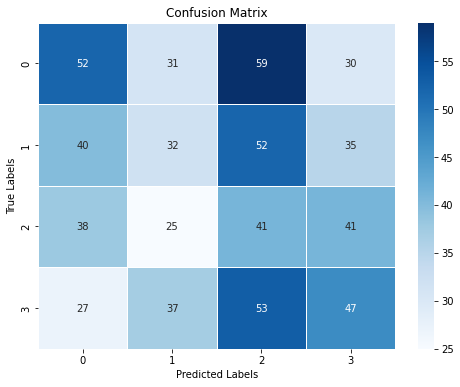

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create a confusion matrix
confusion = confusion_matrix(labels_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_Matrix_SVM.png")
plt.show()

### Single label Prediction - SVC with Quantum Kernel

In [201]:
labels_train_0 = np.where(labels_train==1, 1, 0)
labels_val_0 = np.where(labels_val==1, 1, 0)
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)
zzpc_score_0_train = pauli_svc_0.score(matrix_train_0, labels_train_0)
print(f'Accuracy for training dataset: {zzpc_score_0_train}')

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of val discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy for training dataset: 0.8969729155602761
Accuracy of val discriminating between label 0 and others: 75.14792899408283%


In [72]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.32 0.33 0.31 0.31 0.43 0.24 0.3  0.41 0.37 0.29 0.34 0.5  0.32 0.31
 0.28 0.3  0.31 0.3  0.34 0.28 0.27 0.46 0.31 0.28 0.29 0.35 0.41 0.34
 0.29 0.34 0.29 0.39 0.36 0.43 0.27 0.41 0.34 0.28 0.39 0.4  0.4  0.34
 0.29 0.34 0.34 0.41 0.35 0.36 0.33 0.28 0.35 0.32 0.29 0.34 0.33 0.38
 0.84 0.28 0.33 0.4  0.25 0.27 0.42 0.35 0.29 0.44 0.22 0.27 0.29 0.33
 0.27 0.36 0.27 0.44 0.28 0.37 0.26 0.28 0.35 0.29 0.41 0.31 0.3  0.28
 0.3  0.3  0.26 0.33 0.31 0.75 0.32 0.27 0.46 0.4  0.32 0.3  0.46 0.27
 0.3  0.45 0.28 0.26 0.63 0.31 0.32 0.32 0.31 0.32 0.31 0.28 0.28 0.37
 0.43 0.28 0.29 0.29 0.33 0.31 0.27 0.31 0.34 0.4  0.3  0.27 0.4  0.29
 0.42 0.3  0.3  0.34 0.3  0.3  0.41 0.39 0.21 0.39 0.28 0.31 0.36 0.28
 0.3  0.22 0.28 0.29 0.3  0.21 0.3  0.27 0.28 0.42 0.41 0.3  0.3  0.35
 0.29 0.31 0.31 0.33 0.37 0.31 0.27 0.37 0.26 0.35 0.37 0.28 0.31 0.38
 0.33 0.32 0.3  0.63 0.29 0.37 0.27 0.3  0.29 0.34 0.25 0.62 0.31 0.31
 0.28 0.34 0.26 0.35 0.33 0.3  0.33 0.35 0.28 0.31 0.

In [198]:
##############################
# Provide your code here
labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)

zz_map_2 = ZZFeatureMap(feature_dimension=N_DIM, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel_2 = QuantumKernel(feature_map=zz_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

zzpc_svc_2 = SVC(kernel='precomputed', probability=True)

matrix_train_2 = zz_kernel_2.evaluate(x_vec=sample_train)
zzpc_svc_2.fit(matrix_train_2, labels_train_2)
zzpc_score_2_train = zzpc_svc_2.score(matrix_train_2, labels_train_2)
print(f'Accuracy for training dataset: {zzpc_score_2_train}')

matrix_val_2 = zz_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
zzpc_score_2 = zzpc_svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy for validation dataset: {zzpc_score_2}')

matrix_test_2 = zz_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = zzpc_svc_2.predict_proba(matrix_test_2)[:, 1]


##############################

Accuracy for training dataset: 0.9298990971853426
Accuracy for validation dataset: 0.7514792899408284


In [14]:
# Set a threshold to classify samples
threshold = 0.5
binary_predictions = (pred_2 > threshold).astype(int)

# Compute the confusion matrix
confusion = confusion_matrix(labels_val_2, binary_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

NameError: name 'pred_2' is not defined

In [74]:
pred_2 

array([0.07086556, 0.06424075, 0.06667864, 0.06387431, 0.06654123,
       0.06271046, 0.06114851, 0.07890812, 0.07019718, 0.06513616,
       0.06676615, 0.06539885, 0.0731849 , 0.06889389, 0.07056823,
       0.06625552, 0.06515081, 0.06605548, 0.0635661 , 0.06459   ,
       0.06503411, 0.06527948, 0.07711197, 0.0641016 , 0.03560314,
       0.07580537, 0.07071342, 0.07392562, 0.0837756 , 0.06374346,
       0.06404643, 0.06358795, 0.06693868, 0.06610635, 0.07099561,
       0.06907298, 0.07178703, 0.0657799 , 0.06862538, 0.06567058,
       0.07658951, 0.06726133, 0.07062479, 0.06608691, 0.06662731,
       0.07904173, 0.06505217, 0.06609563, 0.06556653, 0.06624775,
       0.06684731, 0.06513897, 0.05349282, 0.06528358, 0.06440389,
       0.08324752, 0.07593495, 0.06400263, 0.05925591, 0.06795454,
       0.07799366, 0.07133952, 0.06942   , 0.06375196, 0.06395474,
       0.05808143, 0.06207302, 0.06444235, 0.06749205, 0.06882141,
       0.10288285, 0.06600404, 0.06404267, 0.0655758 , 0.07162

In [199]:
##############################
# Provide your code here


labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)

zz_map_3 = ZZFeatureMap(feature_dimension=N_DIM, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel_3 = QuantumKernel(feature_map=zz_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

zzpc_svc_3 = SVC(kernel='precomputed', probability=True)

matrix_train_3 = zz_kernel_3.evaluate(x_vec=sample_train)
zzpc_svc_3.fit(matrix_train_3, labels_train_3)
zzpc_score_3_train = zzpc_svc_3.score(matrix_train_3, labels_train_3)
print(f'Accuracy for training dataset: {zzpc_score_3_train}')

matrix_val_3 = zz_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
zzpc_score_3 = zzpc_svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy for validation dataset: {zzpc_score_3}')

matrix_test_3 = zz_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 = zzpc_svc_3.predict_proba(matrix_test_3)[:, 1]


##############################

Accuracy for training dataset: 0.7055231014338821
Accuracy for validation dataset: 0.6923076923076923


In [76]:
pred_3

array([0.33441188, 0.61357049, 0.71991053, 0.44546349, 0.44466685,
       0.54269887, 0.56958154, 0.40322336, 0.31296215, 0.67431832,
       0.29175984, 0.54805583, 0.71860946, 0.60061227, 0.68527675,
       0.76286884, 0.42810461, 0.70255756, 0.35120198, 0.56072794,
       0.52504827, 0.25930977, 0.76442146, 0.77413361, 0.19195737,
       0.31371444, 0.56068165, 0.22718939, 0.33759002, 0.28207424,
       0.5       , 0.3866409 , 0.55596537, 0.4072856 , 0.69012926,
       0.73303695, 0.41795859, 0.78319432, 0.26460116, 0.69958815,
       0.7106854 , 0.64038327, 0.22974927, 0.40439214, 0.61991901,
       0.37468247, 0.79688928, 0.50666037, 0.41288853, 0.64655996,
       0.30285827, 0.38046432, 0.21002654, 0.09525014, 0.26540466,
       0.61239862, 0.29060307, 0.48492978, 0.41544982, 0.54899196,
       0.26241474, 0.77428362, 0.26123607, 0.5       , 0.75812545,
       0.29752695, 0.44888022, 0.5571683 , 0.4728757 , 0.30661944,
       0.35690767, 0.19260493, 0.76747615, 0.60532237, 0.26616

In [75]:

labels_train_4 = np.where(labels_train==4, 1, 0)
labels_val_4 = np.where(labels_val==4, 1, 0)

In [200]:
##############################
# Provide your code here


labels_train_4 = np.where(labels_train==4, 1, 0)
labels_val_4 = np.where(labels_val==4, 1, 0)

zz_map_4 = ZZFeatureMap(feature_dimension=N_DIM, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel_4 = QuantumKernel(feature_map=zz_map_4, quantum_instance=Aer.get_backend('statevector_simulator'))

zzpc_svc_4 = SVC(kernel='precomputed', probability=True)

matrix_train_4 = zz_kernel_4.evaluate(x_vec=sample_train)
zzpc_svc_4.fit(matrix_train_4, labels_train_4)
zzpc_score_4_train = zzpc_svc_4.score(matrix_train_4, labels_train_4)
print(f'Accuracy for training dataset: {zzpc_score_4_train}')

matrix_val_4 = zz_kernel_4.evaluate(x_vec=sample_val, y_vec=sample_train)
zzpc_score_4 = zzpc_svc_4.score(matrix_val_4, labels_val_4)
print(f'Accuracy for validation dataset: {zzpc_score_4}')

matrix_test_4 = zz_kernel_4.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_4 = zzpc_svc_4.predict_proba(matrix_test_4)[:, 1]


##############################

Accuracy for training dataset: 0.7140201805629315
Accuracy for validation dataset: 0.7692307692307693


In [ ]:
pred_4 

In [ ]:
Accuracy for validation dataset: 0.9319389110225763
Accuracy for validation dataset: 0.9217506631299734

In [202]:
labels_train_4

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])